# Traffic Sign Classification with CNN

1. Citakamalia (1301204122)
2. Ghina Annisa S (1301204082)
3. Iqlima Putri H (1301204337)

<hr>

Dataset: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset German Traffic Sign Benchmark (GTSRB) merupakan dataset multi-class, single image classification dari International Joint Conference on Neural Networks (IJCNN) 2011. Dataset tersebut berisi lebih dari 40 kelas dengan total image lebih dari 50,000 images.

# Classification

In [ ]:
# Fundamental classes
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from google.colab import drive
import zipfile

# Image related
import cv2
from PIL import Image

#Performance Plot
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Time
import time
import datetime

In [ ]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:
        return 'Date today: %s' % datetime.date.today()

In [ ]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

Load Dataset

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
local_zip = '/content/drive/MyDrive/dataset/GTSRB.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Setting variables for later use
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels
for i in range(classes):
    path = os.path.join('/content','train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

Splitting Data

In [ ]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


Building Model

In [ ]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

Training Model

In [ ]:
# Training the Model
with tf.device('/GPU:0'):
    epochs = 25
    history1 = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/25
981/981 [==============================] - 13s 7ms/step - loss: 2.1169 - accuracy: 0.4462 - val_loss: 0.6445 - val_accuracy: 0.8301
Epoch 2/25
981/981 [==============================] - 6s 6ms/step - loss: 0.7188 - accuracy: 0.7840 - val_loss: 0.2813 - val_accuracy: 0.9300
Epoch 3/25
981/981 [==============================] - 5s 5ms/step - loss: 0.4478 - accuracy: 0.8665 - val_loss: 0.1914 - val_accuracy: 0.9463
Epoch 4/25
981/981 [==============================] - 6s 7ms/step - loss: 0.3366 - accuracy: 0.9026 - val_loss: 0.1158 - val_accuracy: 0.9716
Epoch 5/25
981/981 [==============================] - 5s 5ms/step - loss: 0.3029 - accuracy: 0.9129 - val_loss: 0.0889 - val_accuracy: 0.9760
Epoch 6/25
981/981 [==============================] - 5s 5ms/step - loss: 0.2684 - accuracy: 0.9257 - val_loss: 0.0796 - val_accuracy: 0.9786
Epoch 7/25
981/981 [==============================] - 6s 6ms/step - loss: 0.2344 - accuracy: 0.9368 - val_loss: 0.0638 - val_accuracy: 0.9844
Epoch

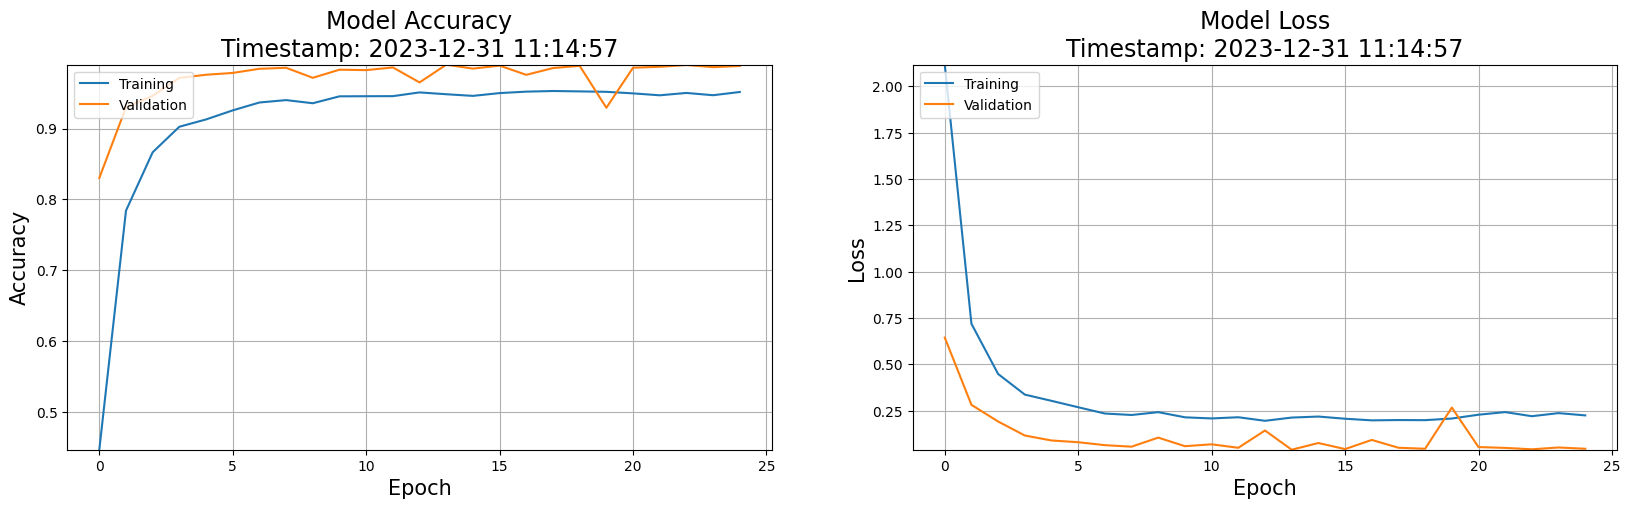

In [ ]:
plot_performance(history=history1)

In [ ]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score

# Importing the test dataset
y_test = pd.read_csv('/content/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([30, 30])
        data.append(np.array(image))

X_test=np.array(data)

In [ ]:
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

395/395 [==============================] - 1s 3ms/step
0.9544734758511481


In [ ]:
from keras.models import load_model, save_model

# Save the model to an HDF5 file
model.save('traffic-sign-classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
